<a href="https://colab.research.google.com/github/RBarroco/network-analytics-tensorflow/blob/main/Network_Analytics_UNR_IDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Analytics

Source: https://www.tapadhirdas.com/unr-idd-dataset

## Data Lineage

**- UNR_IDD**

For this Capstone project we are using data fron the University of Nevada.  Specifically, their Reno Intrusion Detection Dataset (UNR-IDD). The main difference between UNR-IDD and other existing datasets is that UNR-IDD consists primarily of network port statistics. These refer to the observed port metrics recorded in switch/router ports within a networking environment. The dataset also includes delta port statistics which indicates the change in magnitude of observed port statistics within a time interval. Compared to datasets that primarily use flow level statistics, these port statistics can provide a fine-grained analysis of network flows from the port level as decisions are made at the port level versus the flow level. This can lead to rapid identification of potential intrusions. UNR-IDD also address the limitation of the presence of tail classes. The dataset ensures that there are enough samples for ML classifiers to achieve high F-Measure scores, uniquely. Our proposed dataset also ensures that there are no missing network metrics and that all data samples are filled.

**- Flow Simulation**

IPerf is used to create TCP and UDP data streams simulating network flows in virtual and real networks using dummy payloads. By using the Mininet API and IPerf, UNR-IDD created a Python script to simulate realistic network flows. Once every 5 seconds, UNR-IDD initiated Iperf traffic between a randomly chosen source-destination host pair with a bandwidth of 10 Mbps and a duration of 5 seconds. UNR-IDD then simulate flows under normal and intrusion conditions to gather data in every possible scenario. To ensure that each normal and anomaly category is minimally variable and adequately represented, UNR-IDD execute the same number of flows while simulating each scenario.


**- Port Statistics**

The corresponding table shows the collected port statistics and their descriptions per port on every switch in the simulated SDN. These statistics relay the collected metrics and magnitudes from every single port within the SDN when a flow is simulated between two hosts. 


**- Port Statistic**|**Description**
---|---
Received Packets | Number of packets received by the port
Received Bytes |	Number of bytes received by the port
Sent Packets |	Number of packets sent by the port
Sent Bytes |	Number of bytes sent
Port alive | Duration	The time port has been alive in seconds
Packets Rx | Dropped	Number of packets dropped by the receiver
Packets Tx | Dropped	Number of packets dropped by the sender
Packets Rx | Errors	Number of transmit errors
Packets Tx | Errors	Number of receive errors



**- Delta Port Statistics**

The corresponding table illustrates the collected delta port statistics and their descriptions per port on every switch. These delta statistics are used to capture the change in collected metrics from every single port within the SDN when a flow is simulated between two hosts. The time interval for these observed metrics is configured as 5 seconds, which can provide greater detail in detecting intrusions. 


**- Delta Port Statistic**|**Description**
---|---
Delta Received Packets|	Number of packets received by the port
Delta Received Bytes|	Number of bytes received by the port
Delta Sent Packets|	Number of packets sent by the port
Delta Sent Bytes|	Number of bytes sent
Delta Port alive| Duration	The time port has been alive in seconds
Delta Packets Rx| Dropped	Number of packets dropped by the receiver
Delta Packets Tx| Dropped	Number of packets dropped by the sender
Delta Packets Rx| Errors	Number of transmit errors
Delta Packets Tx| Errors	Number of receive errors



**- Flow Entry and Flow Table Statistics**

Additionally, UNR-IDD also collect some flow entry and flow table statistics to work in conjunction with the collected port statistics as seen in the corresponding table. These metrics provide information about the conditions of switches in the network and can be collected in any network setting. 

**Statistic**|**Description**
---|---
Connection Point|	Network connection point expressed as a pair of the network element identifier and port number.
Total Load/Rate|	Obtain the current observed total load/rate (in bytes/s) on a link.
Total Load/Latest|	Obtain the latest total load bytes counter viewed on that link.
Unknown Load/Rate|	Obtain the current observed unknown-sized load/rate (in bytes/s) on a link.
Unknown Load/Latest|	Obtain the latest unknown-sized load bytes counter viewed on that link.
Time seen|	When the above-mentioned values were last seen.
is_valid|	Indicates whether this load was built on valid values.
TableID|	Returns the Table ID values.
ActiveFlowEntries|	Returns the number of active flow entries in this table.
PacketsLookedUp|	Returns the number of packets looked up in the table.
PacketsMatched|	Returns the number of packets that successfully matched in the table.
MaxSize|	Returns the maximum size of this table.




In [1]:
import pandas as pd
upload = pd.read_csv('/content/UNR-IDD.csv')


In [2]:
!pip install TPOT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.2 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11953 sha256=9cf6be5010111979561f363caae14e4cbb401b822de340f776f5d9cf7de76425
  Stored in directory: /root/.cache/pip/wheels/a8/bb/8f/6b9328d23c2dcedbfeb8498b9f650d55d463089e3b8fc0bfb2
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats

# Import several other classifiers for ensemble
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Support tools
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

sns.color_palette()
# Warning
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:.2f}".format

[(0.0941117647058824, 0.0, 0.6549294117647059),
 (0.0, 0.5634078431372549, 0.8667),
 (0.0, 0.6300803921568627, 0.24050784313725487),
 (0.0, 0.9268156862745098, 0.0),
 (0.9516098039215687, 0.8967078431372549, 0.0),
 (0.9764764705882353, 0.0, 0.0)]

### Loading Dataset

In [4]:
import pandas as pd
raw_df = upload

In [5]:
raw_df.head(5)

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
0,of:000000000000000c,Port#:1,132,9181,6311853,238,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
1,of:000000000000000c,Port#:2,187,6304498,15713,171,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
2,of:000000000000000c,Port#:3,235,6311567,8030,58,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
3,of:000000000000000c,Port#:4,59,7878,16439,182,46,0,0,0,...,0,0,True,0,9,767,688,-1,TCP-SYN,Attack
4,of:000000000000000a,Port#:1,188,6304547,16497,183,46,0,0,0,...,0,0,True,0,7,489,403,-1,TCP-SYN,Attack


In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37411 entries, 0 to 37410
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Switch ID                      37411 non-null  object
 1   Port Number                    37411 non-null  object
 2   Received Packets               37411 non-null  int64 
 3   Received Bytes                 37411 non-null  int64 
 4   Sent Bytes                     37411 non-null  int64 
 5   Sent Packets                   37411 non-null  int64 
 6   Port alive Duration (S)        37411 non-null  int64 
 7   Packets Rx Dropped             37411 non-null  int64 
 8   Packets Tx Dropped             37411 non-null  int64 
 9   Packets Rx Errors              37411 non-null  int64 
 10  Packets Tx Errors              37411 non-null  int64 
 11  Delta Received Packets         37411 non-null  int64 
 12  Delta Received Bytes           37411 non-null  int64 
 13  D

**Comment:** Continuous and discrete numerical variables, as well as categorical features.

In [7]:
# Checking for duplicates
raw_df[raw_df.duplicated() == True]

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label
32287,of:000000000000000a,Port#:3,66,9078,8992,63,56,0,0,0,...,0,0,True,0,4,201,123,-1,PortScan,Attack


In [8]:
# drop duplicates
raw_df = raw_df.drop_duplicates()

In [9]:
# Checking for duplicates
raw_df[raw_df.duplicated() == True]

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,...,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label,Binary Label


In [10]:
# Missing values checking
pd.DataFrame(data={'% of Missing Values':round(raw_df.isna().sum()/raw_df.isna().count()*100,2)})

,% of Missing Values
Switch ID,0.00
Port Number,0.00
Received Packets,0.00
Received Bytes,0.00
Sent Bytes,0.00
Sent Packets,0.00
Port alive Duration (S),0.00
Packets Rx Dropped,0.00
Packets Tx Dropped,0.00
Packets Rx Errors,0.00


**No missing values**

In [11]:
# Converting object to categorical features
for i in raw_df:
  if raw_df[i].dtypes == 'object':
    raw_df[i] = raw_df[i].astype('category')

In [12]:
# Numerical columns
num_cols = list(raw_df._get_numeric_data().columns)
num_cols

['Received Packets',
 'Received Bytes',
 'Sent Bytes',
 'Sent Packets',
 'Port alive Duration (S)',
 'Packets Rx Dropped',
 'Packets Tx Dropped',
 'Packets Rx Errors',
 'Packets Tx Errors',
 'Delta Received Packets',
 'Delta Received Bytes',
 'Delta Sent Bytes',
 'Delta Sent Packets',
 'Delta Port alive Duration (S)',
 'Delta Packets Rx Dropped',
 ' Delta Packets Tx Dropped',
 'Delta Packets Rx Errors',
 'Delta Packets Tx Errors',
 'Connection Point',
 'Total Load/Rate',
 'Total Load/Latest',
 'Unknown Load/Rate',
 'Unknown Load/Latest',
 'Latest bytes counter',
 'is_valid',
 'Table ID',
 'Active Flow Entries',
 'Packets Looked Up',
 'Packets Matched',
 'Max Size']

In [13]:
num_cols = ['Received Packets',
 'Received Bytes',
 'Sent Bytes',
 'Sent Packets',
 'Port alive Duration (S)',
 'Packets Rx Dropped',
 'Packets Tx Dropped',
 'Packets Rx Errors',
 'Packets Tx Errors',
 'Delta Received Packets',
 'Delta Received Bytes',
 'Delta Sent Bytes',
 'Delta Sent Packets',
 'Delta Packets Rx Dropped',
 ' Delta Packets Tx Dropped',
 'Delta Packets Rx Errors',
 'Delta Packets Tx Errors',
 'Total Load/Rate',
 'Total Load/Latest',
 'Unknown Load/Rate',
 'Unknown Load/Latest',
 'Latest bytes counter',
 'is_valid',
 'Table ID',
 'Active Flow Entries',
 'Packets Looked Up',
 'Packets Matched',
 'Max Size']

In [14]:
# Categorical columns
cat_cols = ['Label', 'Binary Label', 'Switch ID', 'Port Number','Delta Port alive Duration (S)', 'Connection Point']


In [15]:
# Printing unique values
for i in cat_cols:
  print(f'{i}: {raw_df[i].nunique()}')

Label: 6
Binary Label: 2
Switch ID: 12
Port Number: 4
Delta Port alive Duration (S): 2
Connection Point: 5


In [16]:
# Printing unique values
for i in num_cols:
  print(f'{i}: {raw_df[i].nunique()}')

Received Packets: 9931
Received Bytes: 26044
Sent Bytes: 32456
Sent Packets: 11570
Port alive Duration (S): 1206
Packets Rx Dropped: 1
Packets Tx Dropped: 1
Packets Rx Errors: 1
Packets Tx Errors: 1
Delta Received Packets: 676
Delta Received Bytes: 3635
Delta Sent Bytes: 3476
Delta Sent Packets: 567
Delta Packets Rx Dropped: 1
 Delta Packets Tx Dropped: 1
Delta Packets Rx Errors: 1
Delta Packets Tx Errors: 1
Total Load/Rate: 1297
Total Load/Latest: 1918
Unknown Load/Rate: 1297
Unknown Load/Latest: 1918
Latest bytes counter: 1297
is_valid: 1
Table ID: 1
Active Flow Entries: 44
Packets Looked Up: 9311
Packets Matched: 9318
Max Size: 1


In [17]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Received Packets,37410.00,21619.47,65283.95,9.00,329.00,1170.00,3417.00,352772.00
Received Bytes,37410.00,26475617.27,37030682.73,786.00,91141.50,12630515.00,37832295.00,271592472.00
Sent Bytes,37410.00,24512775.63,34398987.20,5705.00,57803.50,12626588.00,31764531.50,239242994.00
Sent Packets,37410.00,33627.72,88793.99,41.00,347.00,1240.50,3968.00,421598.00
Port alive Duration (S),37410.00,911.12,982.12,26.00,136.00,260.00,1747.00,3317.00
Packets Rx Dropped,37410.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Packets Tx Dropped,37410.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Packets Rx Errors,37410.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Packets Tx Errors,37410.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Delta Received Packets,37410.00,194.96,1087.15,0.00,2.00,4.00,6.00,15695.00


In [18]:
for column in cat_cols:
    print(raw_df[column].value_counts())
    print('-'*50)

PortScan     9499
TCP-SYN      9081
Blackhole    8420
Diversion    5615
Normal       3773
Overflow     1022
Name: Label, dtype: int64
--------------------------------------------------
Attack    33637
Normal     3773
Name: Binary Label, dtype: int64
--------------------------------------------------
of:000000000000000c    5490
of:000000000000000a    5096
of:0000000000000003    4910
of:0000000000000001    3780
of:0000000000000004    3386
of:0000000000000007    2620
of:000000000000000b    2476
of:0000000000000008    2208
of:0000000000000005    2056
of:0000000000000002    1884
of:0000000000000006    1752
of:0000000000000009    1752
Name: Switch ID, dtype: int64
--------------------------------------------------
Port#:1    11903
Port#:2    11846
Port#:3     8960
Port#:4     4701
Name: Port Number, dtype: int64
--------------------------------------------------
5    31534
4     5876
Name: Delta Port alive Duration (S), dtype: int64
--------------------------------------------------
2    111

## Exploratory Data Analysis

- Function: plotting numerical features

In [19]:
# Reference: University of Texas, Great learning
def histogram_boxplot(feature, figsize=(10,7), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='lightblue') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='blue', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

### Univariate analysis (continuous numerical)

In [20]:
num_cols_continuous = ['Received Packets', 'Received Bytes',  'Sent Bytes',
            'Sent Packets', 'Port alive Duration (S)', 'Delta Received Packets',
            'Delta Received Bytes', 'Delta Sent Packets', 'Delta Sent Bytes',
            'Total Load/Rate', 'Total Load/Latest', 'Unknown Load/Rate',
            'Unknown Load/Latest', 'Latest bytes counter', 'Active Flow Entries',
            'Packets Looked Up', 'Packets Matched']

In [21]:
# Mean, Median and Mode
for i in num_cols_continuous:
    mean=raw_df[i].mean()
    median=raw_df[i].median()
    mode=raw_df[i].tolist()[0]
    print(f'Feature: {i}, Mean: {mean}, Median: {median}, Mode: {mode}')

Feature: Received Packets, Mean: 21619.473295910186, Median: 1170.0, Mode: 132
Feature: Received Bytes, Mean: 26475617.26516974, Median: 12630515.0, Mode: 9181
Feature: Sent Bytes, Mean: 24512775.627746593, Median: 12626588.0, Mode: 6311853
Feature: Sent Packets, Mean: 33627.72119754076, Median: 1240.5, Mode: 238
Feature: Port alive Duration (S), Mean: 911.1192729216787, Median: 260.0, Mode: 46
Feature: Delta Received Packets, Mean: 194.96319165998395, Median: 4.0, Mode: 0
Feature: Delta Received Bytes, Mean: 342709.22638331994, Median: 556.0, Mode: 0
Feature: Delta Sent Packets, Mean: 178.08791766907245, Median: 4.0, Mode: 2
Feature: Delta Sent Bytes, Mean: 314520.95797914994, Median: 556.0, Mode: 280
Feature: Total Load/Rate, Mean: 19215.06498262497, Median: 0.0, Mode: 0
Feature: Total Load/Latest, Mean: 514573.41702753276, Median: 0.0, Mode: 0
Feature: Unknown Load/Rate, Mean: 19215.06498262497, Median: 0.0, Mode: 0
Feature: Unknown Load/Latest, Mean: 514573.41702753276, Median: 0.0

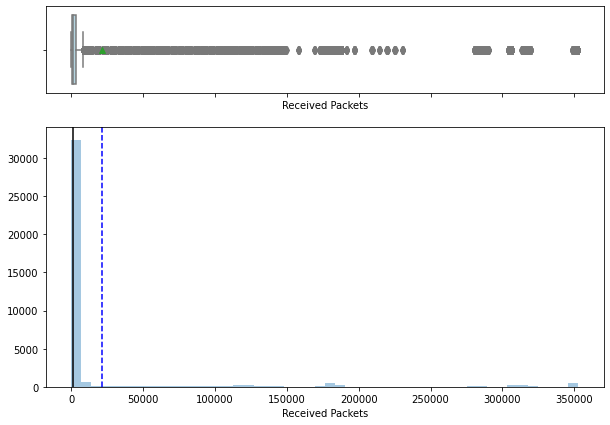

In [22]:
# Numerical continous analysis
histogram_boxplot(raw_df['Received Packets'])

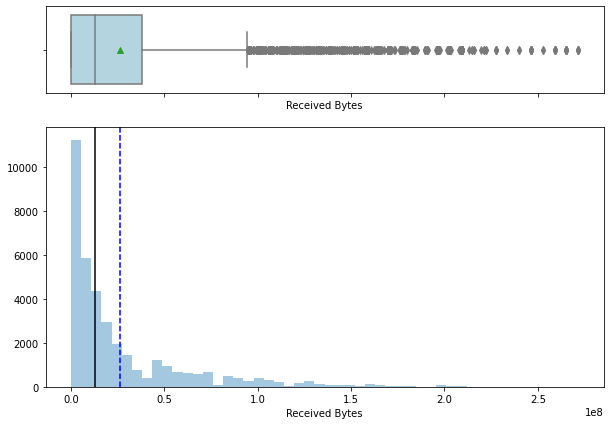

In [23]:
histogram_boxplot(raw_df['Received Bytes'])

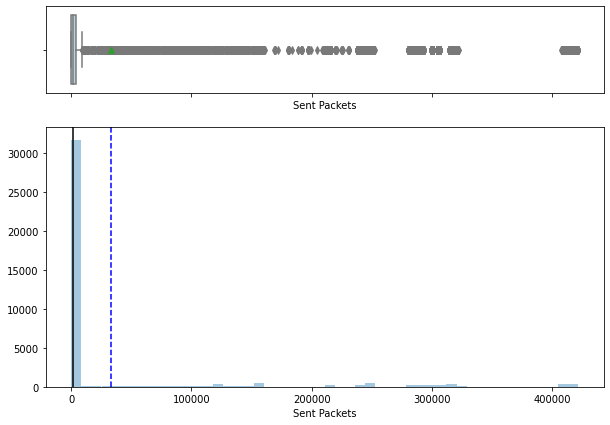

In [24]:
histogram_boxplot(raw_df['Sent Packets'])

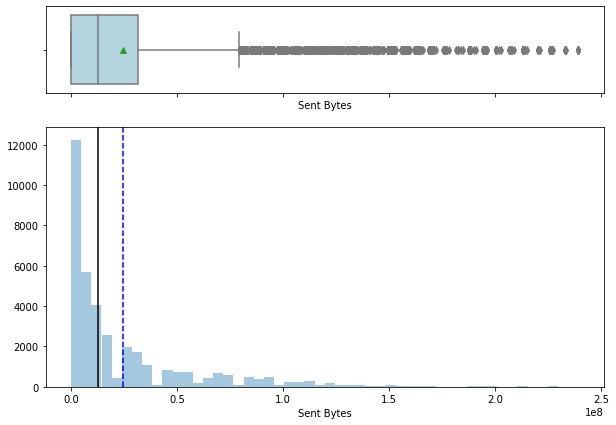

In [25]:
histogram_boxplot(raw_df['Sent Bytes'])

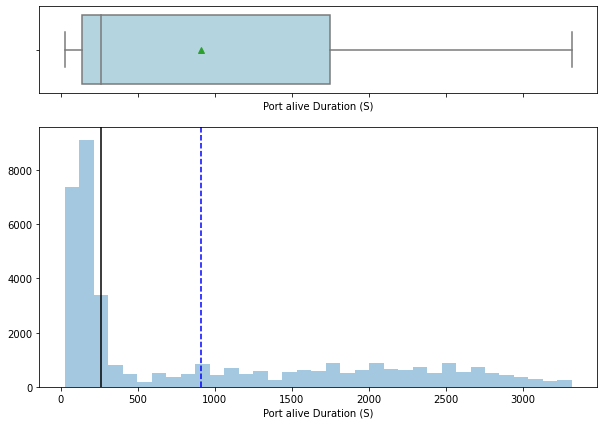

In [26]:
histogram_boxplot(raw_df['Port alive Duration (S)'])

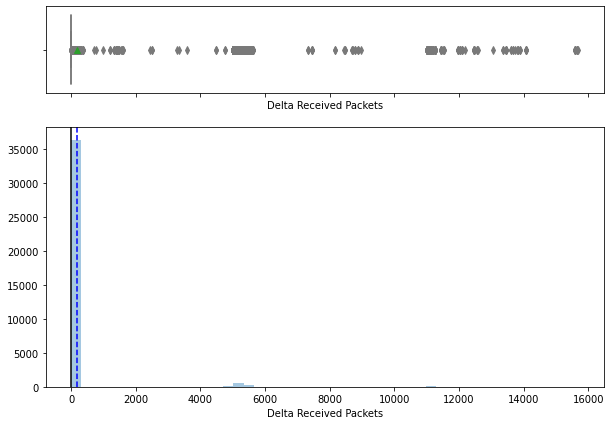

In [27]:
histogram_boxplot(raw_df['Delta Received Packets'])

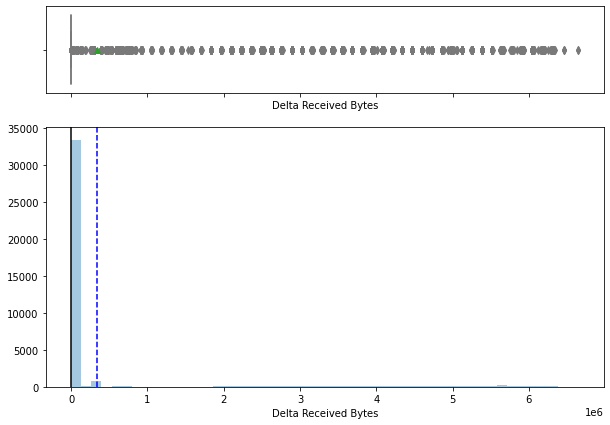

In [28]:
histogram_boxplot(raw_df['Delta Received Bytes'])

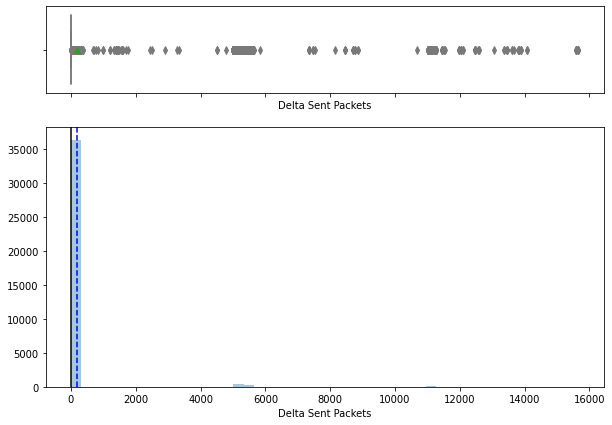

In [29]:
histogram_boxplot(raw_df['Delta Sent Packets'])

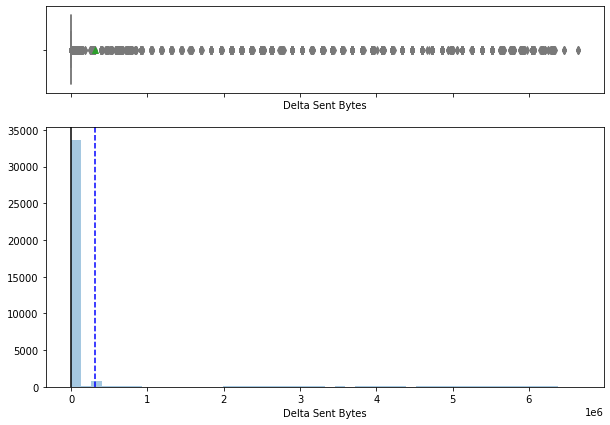

In [30]:
histogram_boxplot(raw_df['Delta Sent Bytes'])

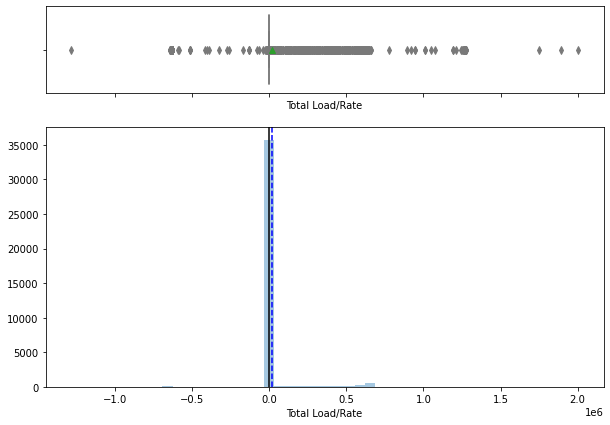

In [31]:
histogram_boxplot(raw_df['Total Load/Rate'])

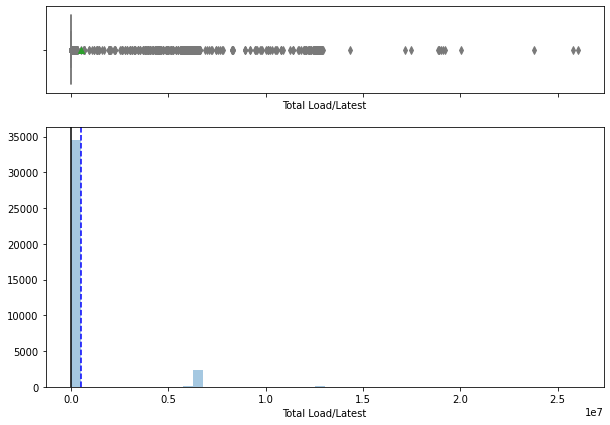

In [32]:
histogram_boxplot(raw_df['Total Load/Latest'])

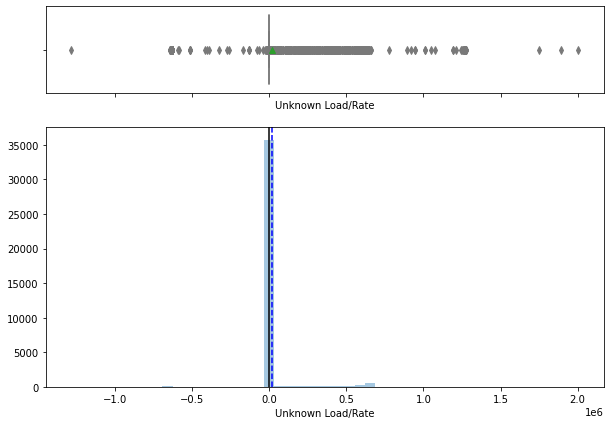

In [33]:
histogram_boxplot(raw_df['Unknown Load/Rate'])

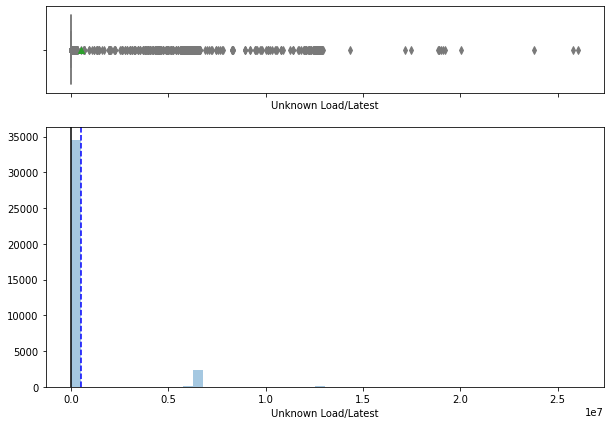

In [34]:
histogram_boxplot(raw_df['Unknown Load/Latest'])

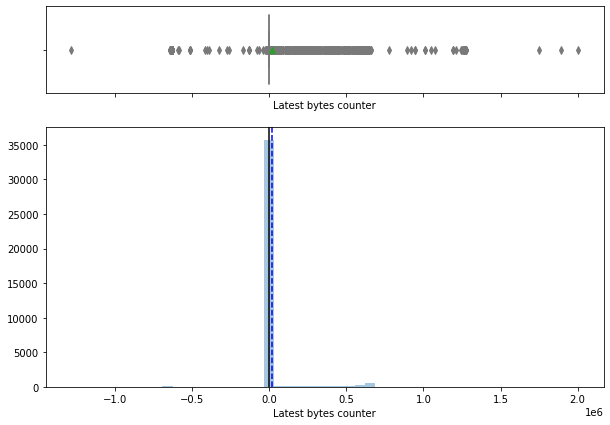

In [35]:
histogram_boxplot(raw_df['Latest bytes counter'])

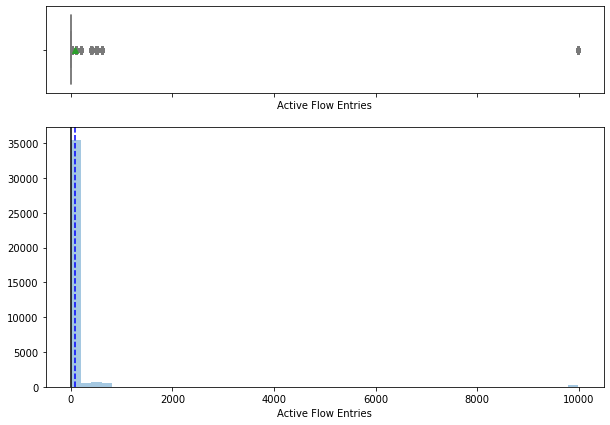

In [36]:
histogram_boxplot(raw_df['Active Flow Entries'])

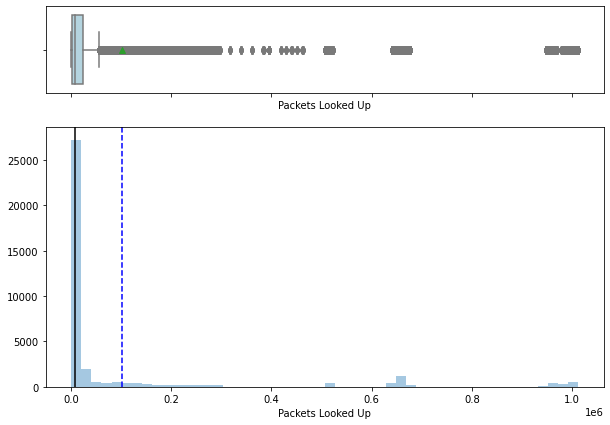

In [37]:
histogram_boxplot(raw_df['Packets Looked Up'])

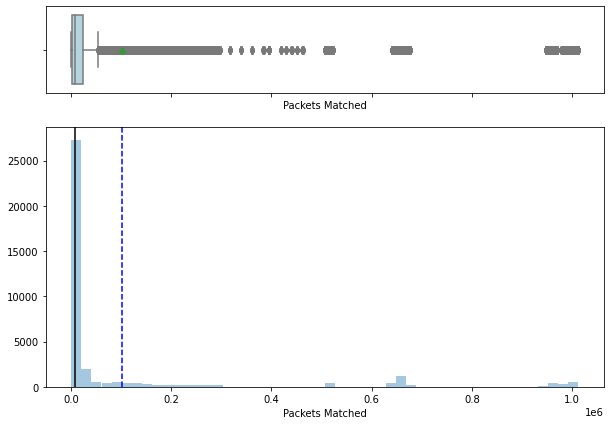

In [38]:
histogram_boxplot(raw_df['Packets Matched'])

### Univariate analysis (discrete numerical)

In [39]:
# Numerical discrete columns
num_cols_discrete = list(set(num_cols) - set(num_cols_continuous))
num_cols_discrete

['Table ID',
 'is_valid',
 'Packets Rx Dropped',
 'Delta Packets Rx Dropped',
 'Packets Rx Errors',
 'Delta Packets Rx Errors',
 'Packets Tx Errors',
 'Packets Tx Dropped',
 'Max Size',
 ' Delta Packets Tx Dropped',
 'Delta Packets Tx Errors']

In [40]:
# Mean, Median and Mode
for i in num_cols_discrete:
    mean=raw_df[i].mean()
    median=raw_df[i].median()
    mode=raw_df[i].tolist()[0]
    print(f'Feature: {i}, Mean: {mean}, Median: {median}, Mode: {mode}')

Feature: Table ID, Mean: 0.0, Median: 0.0, Mode: 0
Feature: is_valid, Mean: 1.0, Median: 1.0, Mode: True
Feature: Packets Rx Dropped, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Delta Packets Rx Dropped, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Packets Rx Errors, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Delta Packets Rx Errors, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Packets Tx Errors, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Packets Tx Dropped, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Max Size, Mean: -1.0, Median: -1.0, Mode: -1
Feature:  Delta Packets Tx Dropped, Mean: 0.0, Median: 0.0, Mode: 0
Feature: Delta Packets Tx Errors, Mean: 0.0, Median: 0.0, Mode: 0


**Comments:** We will probably drop all these features 

### Univariate analysis (categorical features)

- Function: plotting categorical features

In [41]:
# Reference: University of Texas, Great learning
# Function to create barplots that indicate percentage for each category.
def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

In [42]:
cat_cols

['Label',
 'Binary Label',
 'Switch ID',
 'Port Number',
 'Delta Port alive Duration (S)',
 'Connection Point']

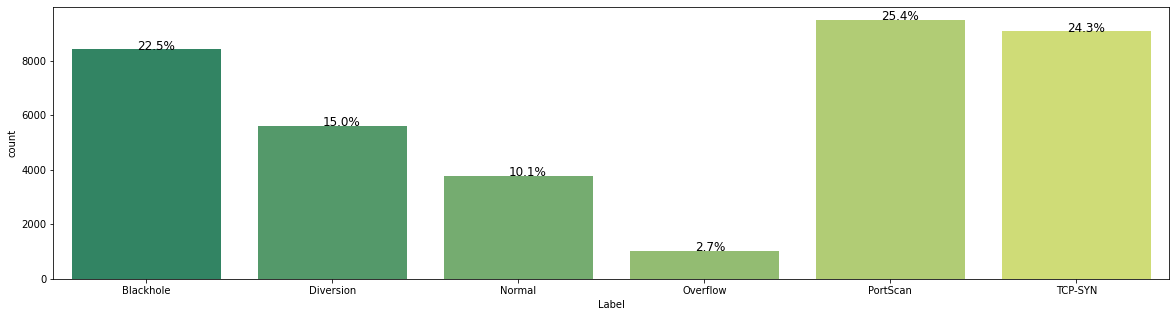

In [43]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Label'],palette='summer')
perc_on_bar(ax,raw_df['Label'])

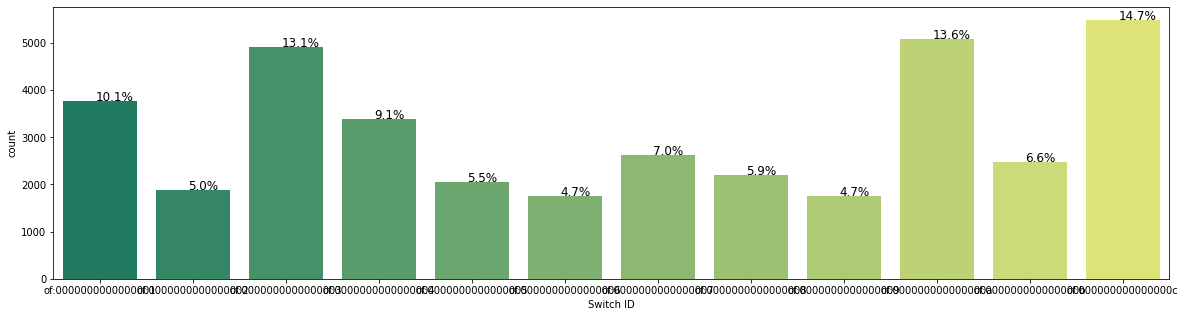

In [44]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Switch ID'],palette='summer')
perc_on_bar(ax,raw_df['Switch ID'])

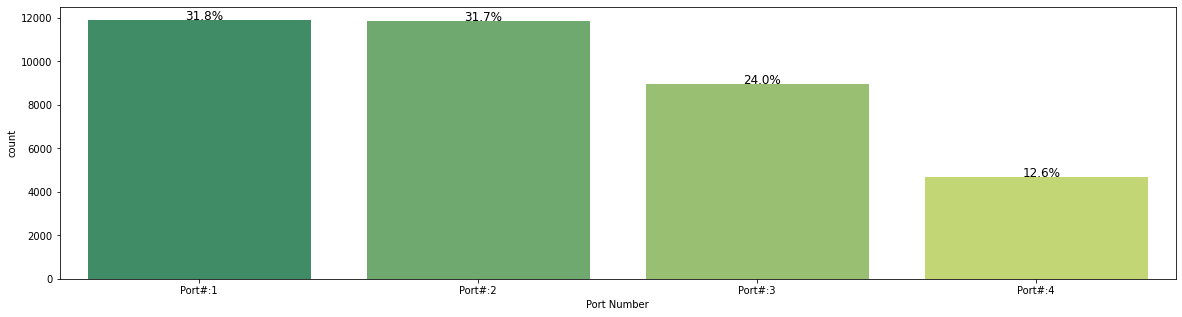

In [45]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Port Number'],palette='summer')
perc_on_bar(ax,raw_df['Port Number'])

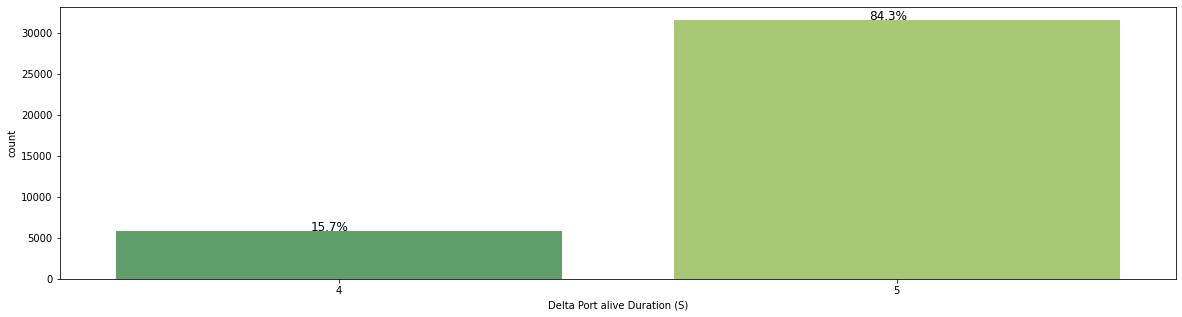

In [46]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Delta Port alive Duration (S)'],palette='summer')
perc_on_bar(ax,raw_df['Delta Port alive Duration (S)'])

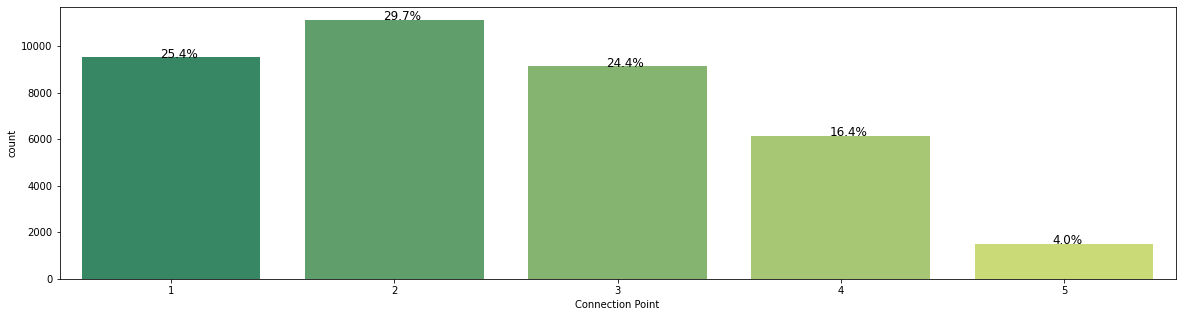

In [47]:
# 
plt.figure(figsize=(20,5))
ax = sns.countplot(raw_df['Connection Point'],palette='summer')
perc_on_bar(ax,raw_df['Connection Point'])

### Bivariate analysis (categorical features)

In [48]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    tab1 = pd.crosstab(x,raw_df["Label"],margins=True)
    print(tab1)
    print('-'*120)
    tab2 = pd.crosstab(x,raw_df["Label"],margins=True, normalize="index")
    print(tab2)
    print('-'*120)
    tab = pd.crosstab(x,raw_df["Label"],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(15,4))
    total = len(x) # length of the column
    plt.legend(loc='lower left', frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.xticks(rotation=0)
    plt.show()

In [49]:
cat_cols

['Label',
 'Binary Label',
 'Switch ID',
 'Port Number',
 'Delta Port alive Duration (S)',
 'Connection Point']

Label        Blackhole  Diversion  Normal  Overflow  PortScan  TCP-SYN    All
Port Number                                                                  
Port#:1           2680       1792    1179       375      3000     2877  11903
Port#:2           2680       1792    1179       321      3000     2874  11846
Port#:3           2100       1115     709       207      2499     2330   8960
Port#:4            960        916     706       119      1000     1000   4701
All               8420       5615    3773      1022      9499     9081  37410
------------------------------------------------------------------------------------------------------------------------
Label        Blackhole  Diversion  Normal  Overflow  PortScan  TCP-SYN
Port Number                                                           
Port#:1           0.23       0.15    0.10      0.03      0.25     0.24
Port#:2           0.23       0.15    0.10      0.03      0.25     0.24
Port#:3           0.23       0.12    0.08      0.

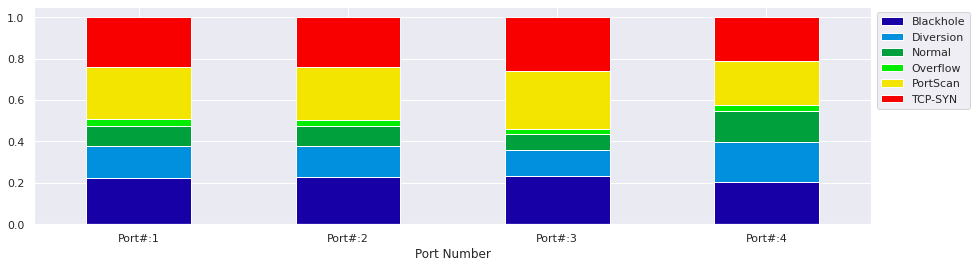

In [50]:
stacked_plot(raw_df['Port Number'])

Label                Blackhole  Diversion  Normal  Overflow  PortScan  \
Switch ID                                                               
of:0000000000000001        960        796       0        40      1000   
of:0000000000000002        480        398       0        14       500   
of:0000000000000003        960        956     942        68      1000   
of:0000000000000004        720        677     468        33       750   
of:0000000000000005        620          0       0         0       750   
of:0000000000000006        420          0       0         0       750   
of:0000000000000007        720        398       0        14       750   
of:0000000000000008        720          0       0         0       750   
of:0000000000000009        420          0       0         0       750   
of:000000000000000a        960        956     944       211       999   
of:000000000000000b        480        478     472        51       500   
of:000000000000000c        960        956     947  

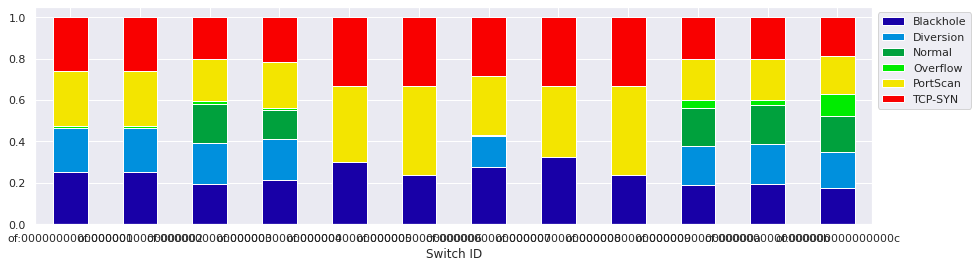

In [51]:
stacked_plot(raw_df['Switch ID'])

Label                          Blackhole  Diversion  Normal  Overflow  \
Delta Port alive Duration (S)                                           
4                                   1101        619    1007       295   
5                                   7319       4996    2766       727   
All                                 8420       5615    3773      1022   

Label                          PortScan  TCP-SYN    All  
Delta Port alive Duration (S)                            
4                                  1422     1432   5876  
5                                  8077     7649  31534  
All                                9499     9081  37410  
------------------------------------------------------------------------------------------------------------------------
Label                          Blackhole  Diversion  Normal  Overflow  \
Delta Port alive Duration (S)                                           
4                                   0.19       0.11    0.17      0.05   
5   

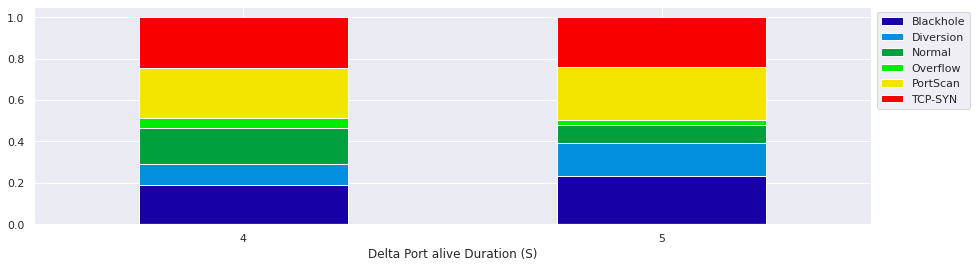

In [52]:
stacked_plot(raw_df['Delta Port alive Duration (S)'])

Label             Blackhole  Diversion  Normal  Overflow  PortScan  TCP-SYN  \
Connection Point                                                              
1                      2480          0     943       220      3000     2874   
2                      2540       1593    1177       282      2921     2611   
3                      1720       1752     707       205      2499     2248   
4                      1680       1354     942       255       829     1089   
5                         0        916       4        60       250      259   
All                    8420       5615    3773      1022      9499     9081   

Label               All  
Connection Point         
1                  9517  
2                 11124  
3                  9131  
4                  6149  
5                  1489  
All               37410  
------------------------------------------------------------------------------------------------------------------------
Label             Blackhole  Diversion

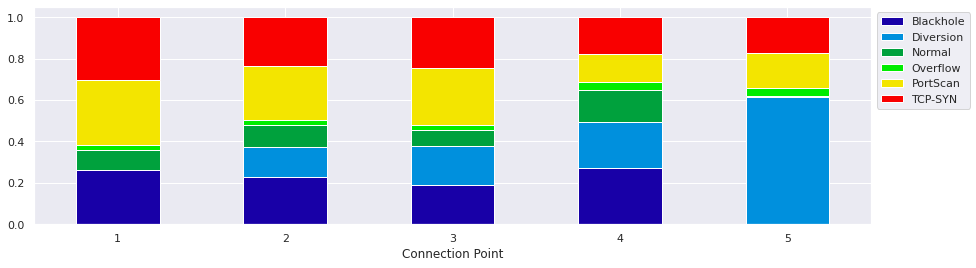

In [53]:
stacked_plot(raw_df['Connection Point'])

### Bivariate Analysis

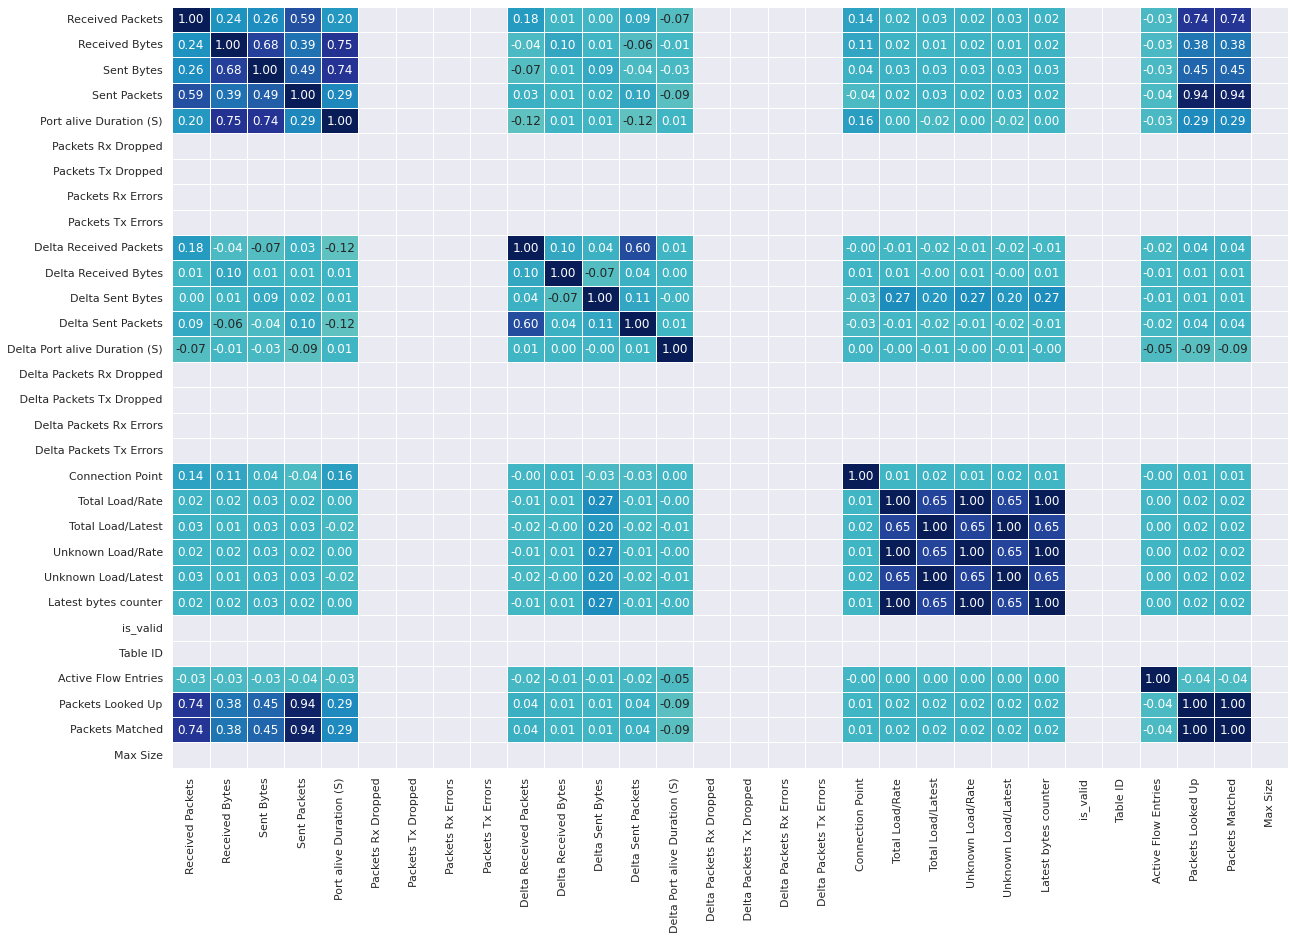

In [54]:
plt.figure(figsize=(20,14))

sns.heatmap(raw_df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu",
            fmt='0.2f')            

plt.show()

**Comment:** Here we can see plenty of opportunity to drop features that won't impact much on our analysis. Some of them inclusive are filled with only zeros.


In [55]:
raw_df.columns

Index(['Switch ID', 'Port Number', 'Received Packets', 'Received Bytes',
       'Sent Bytes', 'Sent Packets', 'Port alive Duration (S)',
       'Packets Rx Dropped', 'Packets Tx Dropped', 'Packets Rx Errors',
       'Packets Tx Errors', 'Delta Received Packets', 'Delta Received Bytes',
       'Delta Sent Bytes', 'Delta Sent Packets',
       'Delta Port alive Duration (S)', 'Delta Packets Rx Dropped',
       ' Delta Packets Tx Dropped', 'Delta Packets Rx Errors',
       'Delta Packets Tx Errors', 'Connection Point', 'Total Load/Rate',
       'Total Load/Latest', 'Unknown Load/Rate', 'Unknown Load/Latest',
       'Latest bytes counter', 'is_valid', 'Table ID', 'Active Flow Entries',
       'Packets Looked Up', 'Packets Matched', 'Max Size', 'Label',
       'Binary Label'],
      dtype='object')

In [56]:
cleanned_df = raw_df[['Switch ID',
                     'Port Number',
                     'Received Packets',
                     'Received Bytes',
                     'Sent Bytes',
                     'Sent Packets',
                     'Port alive Duration (S)',
                     'Delta Received Packets',
                     'Delta Received Bytes',
                     'Delta Sent Bytes',
                     'Delta Sent Packets',
                     'Delta Port alive Duration (S)',
                     'Connection Point',
                     'Total Load/Rate',
                     'Total Load/Latest',
                    #  'Unknown Load/Rate',
                     'Unknown Load/Latest',
                    #  'Latest bytes counter',
                     'Active Flow Entries',
                     'Packets Matched',
                     'Label',
                     'Binary Label']]

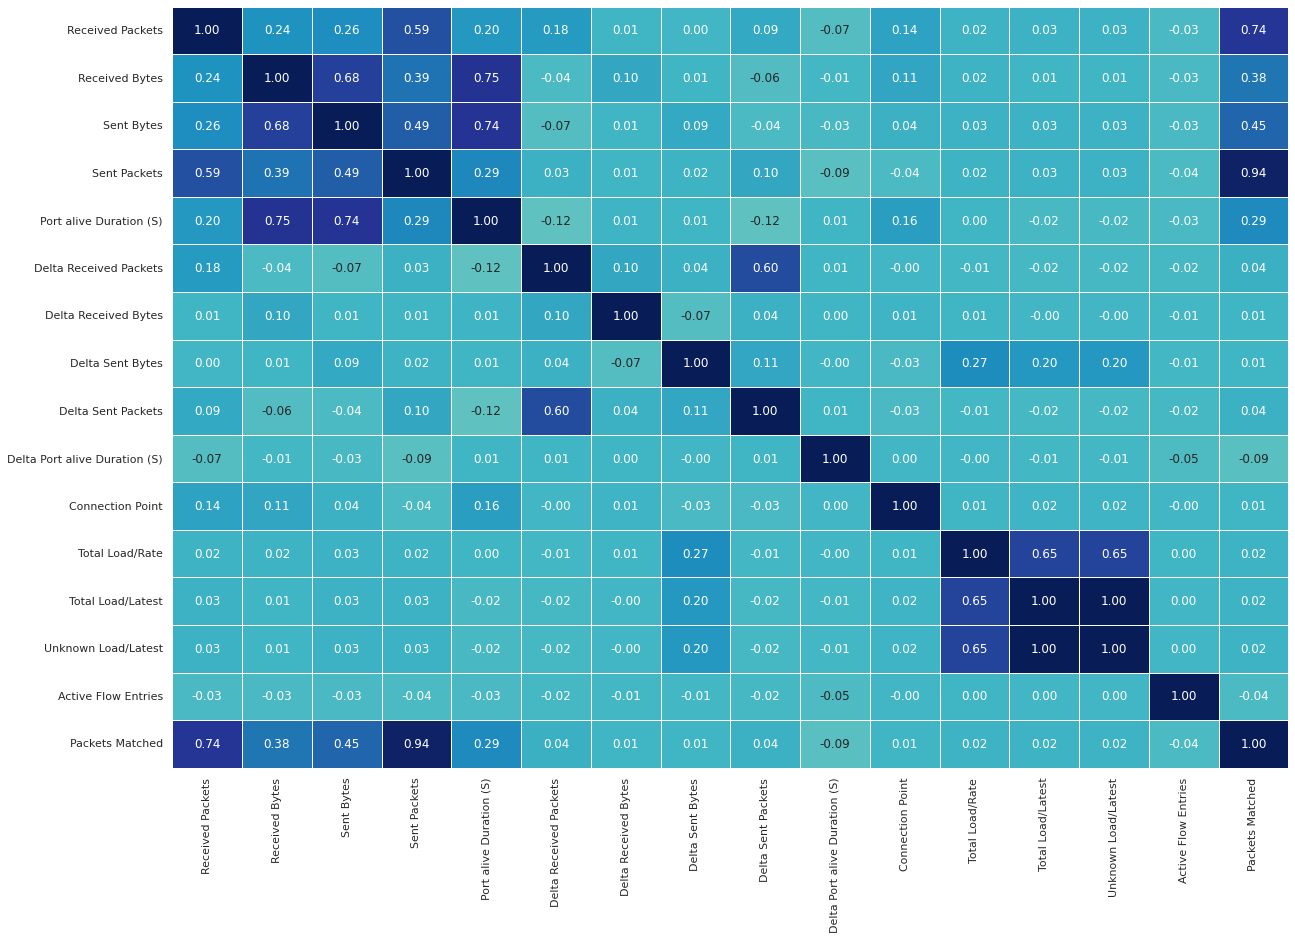

In [57]:
plt.figure(figsize=(20,14))

sns.heatmap(cleanned_df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu",
            fmt='0.2f')            

plt.show()

In [58]:
# Reference: University of Texas, Great learning
from scipy import stats
# Applying Chi-Square test over target feature Attition_Flag
for i in cat_cols:  
  crosstab = pd.crosstab(raw_df['Label'],raw_df[i])  

  Ho = "ProdTaken has --NO-- effect on " + i   # Stating the Null Hypothesis
  Ha = "ProdTaken has an effect on " + i   # Stating the Alternate Hypothesis

  chi, p_value, dof, expected =  stats.chi2_contingency(crosstab)

  if p_value < 0.05:  # Setting our significance level at 5%
      print(f'{Ha} as the p_value ({p_value.round(3)}) < 0.05')
  else:
      print(f'{Ho} as the p_value ({p_value.round(3)}) > 0.05')

ProdTaken has an effect on Label as the p_value (0.0) < 0.05
ProdTaken has an effect on Binary Label as the p_value (0.0) < 0.05
ProdTaken has an effect on Switch ID as the p_value (0.0) < 0.05
ProdTaken has an effect on Port Number as the p_value (0.0) < 0.05
ProdTaken has an effect on Delta Port alive Duration (S) as the p_value (0.0) < 0.05
ProdTaken has an effect on Connection Point as the p_value (0.0) < 0.05


In [59]:
# Saving data prior to Preparation
df_saved = cleanned_df.copy()

In [60]:
# Preprocessing dataFrame
df_start = df_saved.copy()

In [61]:
df_start.to_csv('cleanned.csv')

## Data Pre-processing

- Prepare the data for analysis
- Missing value treatment
- Outlier detection
- Feature Engineering
- Prepare data for modeling

In [62]:
# X has features but not target value
X_prep = df_start.drop(['Binary Label', 'Label'], axis=1)


# y only has target value
y_prep = df_start['Label']

In [63]:
# Transforming categorical features into dummies variables
X_prep_cat = pd.get_dummies(X_prep, drop_first=True)

In [64]:
# Label encoding target feature
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_prep = le.fit_transform(y_prep)

In [65]:
print(X_prep_cat.shape)
print(y_prep.shape)

(37410, 30)
(37410,)


In [66]:
# Saving dataset prior to treat for outliers
X_saved = X_prep_cat
y_saved = y_prep

##### Moment of splitting

In [67]:
y_prep_cat = pd.DataFrame(y_prep)

In [68]:
X_prep_cat.to_csv('X_prep_cat.csv')
y_prep_cat.to_csv('y_prep_cat.csv')

In [69]:
print(X_prep_cat.shape)
print(y_prep_cat.shape)

(37410, 30)
(37410, 1)


## Dataset

In [70]:
# First split in Train (0.80) vs. Test (0.20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep_cat, y_prep_cat, test_size=0.3, random_state=42)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Imbalanced dataset

In [71]:
print(X_train.shape)
print(y_train.shape)

(26187, 30)
(26187, 1)


In [72]:
y_train.value_counts()

4    6617
5    6279
0    5991
1    3919
2    2659
3     722
dtype: int64

In [73]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [74]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(26187, 30)
(26187, 1)
(11223, 30)
(11223, 1)


 # Network Analytics with Scikit Learn

#### Using TPOT to find best model for Label;

In [75]:
%%time

from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=3, 
                      population_size=8,
                      scoring='accuracy',
                      mutation_rate=0.9,
                      crossover_rate=0.1,
                      cv = 3,
                      max_eval_time_mins=5,
                      verbosity=2,
                      n_jobs=1,
                      random_state=42)
tpot.fit(X_train, y_train)
print(f"Tpop score on test data: {tpot.score(X_test, y_test):.2f}")
tpot.export('model.py')

Best pipeline: ExtraTreesClassifier(ExtraTreesClassifier(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=7, min_samples_split=8, n_estimators=100), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=18, min_samples_split=9, n_estimators=100)

Tpop score on test data: 0.95


In [76]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: 0.9344713025547028
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.4, min_samples_leaf=7, min_samples_split=8, n_estimators=100)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.35000000000000003, min_samples_leaf=18, min_samples_split=9, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

### Results for classic machine learning

In [77]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

((37410, 30), (37410,))

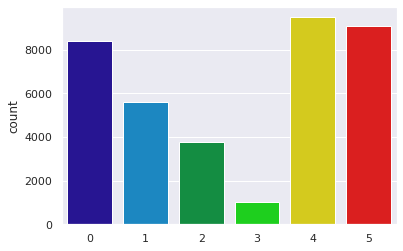

In [78]:
X_saved.shape, y_saved.shape

_ = sns.countplot(y_saved)

In [79]:
print(classification_report(y_test, results))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2429
           1       0.99      0.98      0.99      1696
           2       1.00      1.00      1.00      1114
           3       0.95      0.76      0.85       300
           4       0.91      0.92      0.92      2882
           5       0.90      0.92      0.91      2802

    accuracy                           0.95     11223
   macro avg       0.96      0.93      0.94     11223
weighted avg       0.95      0.95      0.95     11223



In [80]:
cm = confusion_matrix(y_test, results)

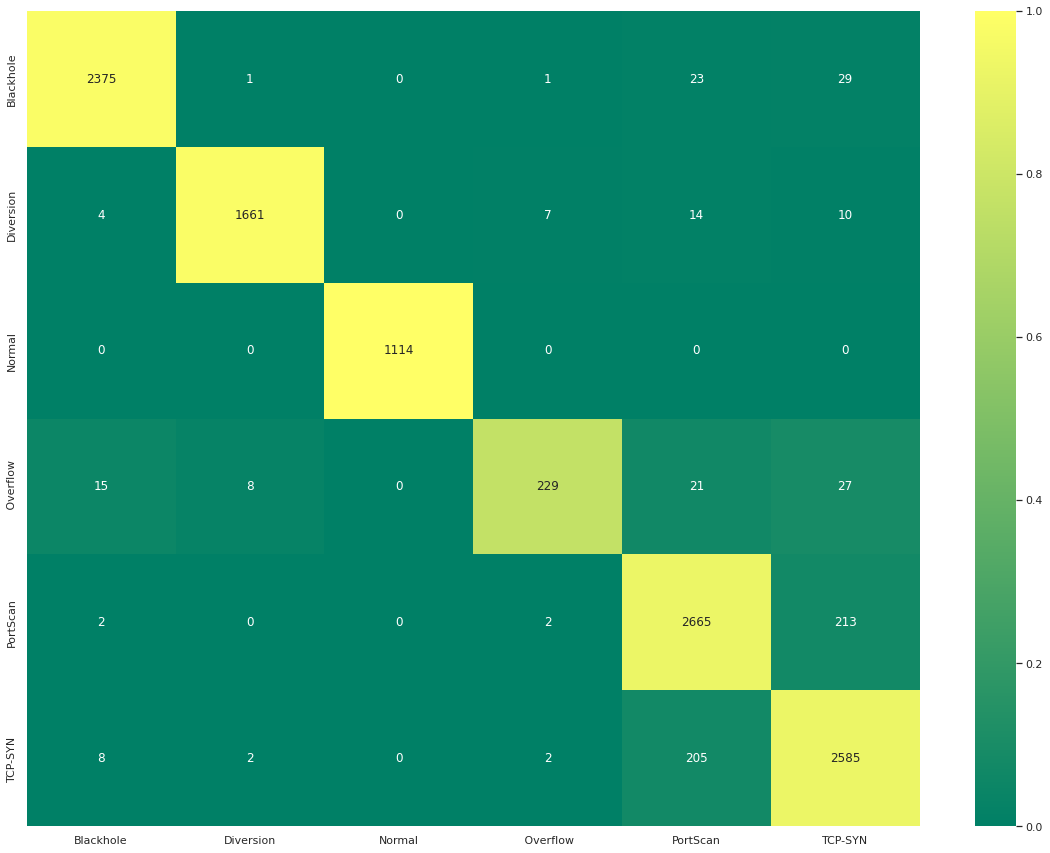

In [81]:
# Stack over flow
def plot_confusion_matrix(cm, classes, normalized=True, cmap='summer'):
    plt.figure(figsize=[20, 15])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

plot_confusion_matrix(cm, ['Blackhole', 'Diversion', 'Normal', ' Overflow',  'PortScan',  'TCP-SYN'])

# Network Analytics with Tensorflow

https://www.tensorflow.org/tutorials/structured_data/feature_columns

**Chat GPT template**

**One hot Enconding target value**

In [82]:
df_start.shape

(37410, 20)

In [83]:
# Transforming categorical features into dummies variables
df_start_cat = pd.get_dummies(df_start, drop_first=True)

In [89]:
df_start_cat.columns

Index(['Received Packets', 'Received Bytes', 'Sent Bytes', 'Sent Packets',
       'Port alive Duration (S)', 'Delta Received Packets',
       'Delta Received Bytes', 'Delta Sent Bytes', 'Delta Sent Packets',
       'Delta Port alive Duration (S)', 'Connection Point', 'Total Load/Rate',
       'Total Load/Latest', 'Unknown Load/Latest', 'Active Flow Entries',
       'Packets Matched', 'Switch ID_of:0000000000000002',
       'Switch ID_of:0000000000000003', 'Switch ID_of:0000000000000004',
       'Switch ID_of:0000000000000005', 'Switch ID_of:0000000000000006',
       'Switch ID_of:0000000000000007', 'Switch ID_of:0000000000000008',
       'Switch ID_of:0000000000000009', 'Switch ID_of:000000000000000a',
       'Switch ID_of:000000000000000b', 'Switch ID_of:000000000000000c',
       'Port Number_Port#:2', 'Port Number_Port#:3', 'Port Number_Port#:4',
       'Label_Diversion', 'Label_Normal', 'Label_Overflow', 'Label_PortScan',
       'Label_TCP-SYN', 'Binary Label_Normal'],
      dtype='

In [91]:
# X has features but not target value
X = df_start_cat.drop(['Label_Diversion', 'Label_Normal', 'Label_Overflow', 'Label_PortScan',
       'Label_TCP-SYN', 'Binary Label_Normal'], axis=1)

In [93]:
# y only has target value
y = df_start_cat[['Label_Diversion', 'Label_Normal', 'Label_Overflow', 'Label_PortScan', 'Label_TCP-SYN']]

In [96]:
X.shape

(37410, 30)

In [95]:
y.shape

(37410, 5)

### Base model

In [109]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define model
model = keras.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=50, validation_split=0.3)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# Make predictions
predictions = model.predict(X_test)


Epoch 1/50
367/367 [==============================] - 2s 4ms/step - loss: 167234.9219 - accuracy: 0.3241 - val_loss: 11095.8643 - val_accuracy: 0.1993
Epoch 2/50
367/367 [==============================] - 2s 5ms/step - loss: 5250.3394 - accuracy: 0.4241 - val_loss: 11082.5527 - val_accuracy: 0.4508
Epoch 3/50
367/367 [==============================] - 1s 3ms/step - loss: 4272.8818 - accuracy: 0.3920 - val_loss: 2907.7446 - val_accuracy: 0.4227
Epoch 4/50
367/367 [==============================] - 1s 3ms/step - loss: 3256.7693 - accuracy: 0.4144 - val_loss: 2935.0815 - val_accuracy: 0.5054
Epoch 5/50
367/367 [==============================] - 1s 3ms/step - loss: 3376.5129 - accuracy: 0.4185 - val_loss: 3051.0620 - val_accuracy: 0.5119
Epoch 6/50
367/367 [==============================] - 1s 3ms/step - loss: 2957.2798 - accuracy: 0.4192 - val_loss: 3945.5215 - val_accuracy: 0.4974
Epoch 7/50
367/367 [==============================] - 1s 3ms/step - loss: 2345.2710 - accuracy: 0.4548 - val

351/351 [==============================] - 1s 2ms/step - loss: 0.6286 - accuracy: 0.2654
Test loss: 0.6286026835441589, Test accuracy: 0.2654370367527008
351/351 [==============================] - 1s 1ms/step


**Comments:**

- val_loss starts increasing, val_acc starts decreasing. This means model is cramming values not learning

- val_loss starts increasing, val_acc also increases.This could be case of overfitting or diverse probability values in cases where softmax is being used in output layer

- val_loss starts decreasing, val_acc starts increasing. This is also fine as that means model built is learning and working fine.

**Chat GPT Comments:**

Increase the size of the training data: A larger training dataset can help the model learn more patterns in the data, which can lead to better performance.

Tune hyperparameters: You can experiment with different hyperparameters such as the learning rate, batch size, number of neurons, and activation functions to find the best combination for your problem.

Use regularization techniques: Regularization techniques such as dropout or L2 regularization can prevent overfitting by reducing the complexity of the model.

Use an appropriate loss function: The choice of loss function can affect the performance of the model. For multi-label classification, binary cross-entropy is a common choice, but you can also try other loss functions such as categorical cross-entropy or hinge loss.

Use an appropriate evaluation metric: Accuracy may not be the best evaluation metric for multi-label classification, especially if the classes are imbalanced. You can use other metrics such as precision, recall, F1-score, or area under the receiver operating characteristic curve (AUC-ROC).

Try different architectures: You can experiment with different architectures such as adding more layers or changing the number of neurons in each layer.

### ChatGPT HyperTunning example

In [108]:
# Define model function

def create_model(units=30, dropout_rate=0.5):
    model = keras.Sequential([
        keras.layers.Dense(units, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(units, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(5, activation='softmax')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create Keras classifier for GridSearchCV
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameters to tune
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [25, 50, 100],
    'dropout_rate': [0.2, 0.5, 0.8]
}

# Use GridSearchCV to find the best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Print results
print(f'Best score: {grid_result.best_score_} using {grid_result.best_params_}')

Best score: 0.2608546217282613 using {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50}


### Renato RandomSearchCV

In [116]:
# https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [118]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00


In [143]:
from keras_tuner import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(hp.Choice('units', [15, 25, 30]),
                           activation=hp.Choice('activation', values=['relu', 'sigmoid', 'tanh']))),
    model.add(layers.Dense(5, activation='softmax')),
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the RandomSearch object
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='my_dir',
                     project_name='my_project')

# Train the model using the RandomSearch object
tuner.search(X_train, y_train, validation_data=(X_val, y_val))

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

**Scoring best model**

In [146]:
# Train model
model.fit(X_train, y_train, epochs=32, batch_size=50, validation_split=0.3, callbacks=[early_stop])

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# Make predictions
predictions = model.predict(X_test)

Epoch 1/32
315/315 [==============================] - 3s 8ms/step - loss: 6527.7979 - accuracy: 0.5164 - val_loss: 4601.7363 - val_accuracy: 0.5719
Epoch 2/32
315/315 [==============================] - 2s 7ms/step - loss: 6540.9331 - accuracy: 0.5168 - val_loss: 6613.9482 - val_accuracy: 0.3521
Epoch 3/32
315/315 [==============================] - 2s 5ms/step - loss: 6761.5078 - accuracy: 0.5083 - val_loss: 9481.2549 - val_accuracy: 0.3170
Epoch 4/32
315/315 [==============================] - 1s 3ms/step - loss: 6679.4531 - accuracy: 0.5101 - val_loss: 7244.2642 - val_accuracy: 0.5754
Epoch 5/32
315/315 [==============================] - 1s 3ms/step - loss: 5506.3726 - accuracy: 0.5269 - val_loss: 7339.8057 - val_accuracy: 0.5806
Epoch 6/32
315/315 [==============================] - 1s 3ms/step - loss: 6586.7837 - accuracy: 0.5081 - val_loss: 5045.9590 - val_accuracy: 0.5469


234/234 [==============================] - 0s 2ms/step - loss: 5718.1333 - accuracy: 0.5385
Test loss: 5718.13330078125, Test accuracy: 0.5384923815727234
234/234 [==============================] - 0s 2ms/step
